In [5]:
from openseespy import opensees as ops
from display import display_structure
from structural.structure import (TenBarsPlanarTruss, AbstractStructure)
from structural.analysis import LinearAnalysis
from dataset import TenBarsPlanarTrussGenerator
import numpy as np 


In [6]:
g = TenBarsPlanarTrussGenerator(
        {'n_sample': 3,
         'parameters': {'load': {'distribution': 'normal', 'mean': 0, 'std': 50.e3}, 'P_y_4': {"shared_with": 'load', 'factor':0.5},
                 'P_y_5': {"shared_with": 'load'}}}
        )

g = TenBarsPlanarTrussGenerator("data/config/10_bar_truss.yaml")

In [7]:
print(g.config)

{'n_sample': 5, 'parameters': {'__young__': {'distribution': 'uniform', 'low': '70e9', 'high': '210.e9'}, '__area__': {'distribution': 'constant', 'value': 0.001}, 'load': {'distribution': 'uniform', 'low': '1.e3', 'high': '1000.e3'}, 'P_y_4': {'shared_with': 'load', 'factor': 1.0}, 'P_y_5': {'shared_with': 'load', 'factor': 1.0}, 'height': {'distribution': 'uniform', 'low': 0.5, 'high': 4.0}}}


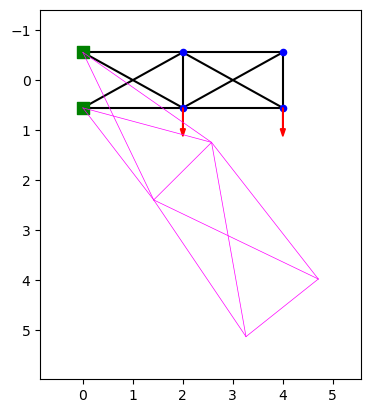

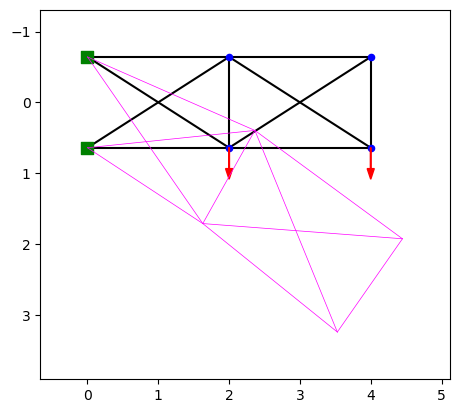

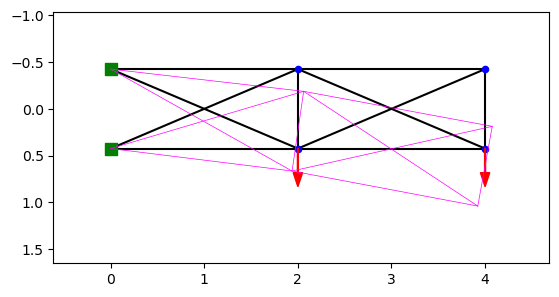

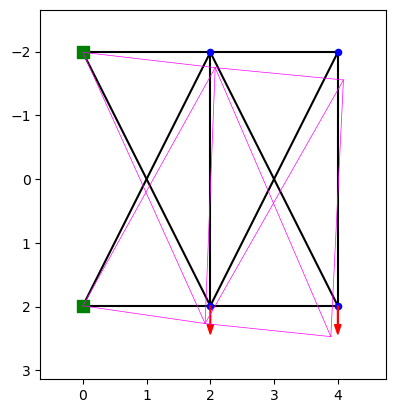

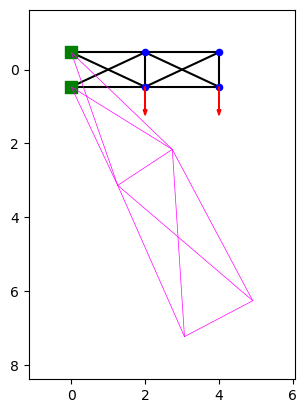

In [9]:
for r in g:
    display_structure(def_scale=10)